In [1]:
import os
import numpy as np
import pandas as pd
import json
import random
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K 

In [2]:
img_dims = (512, 512, 3)

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data_folder, task="train", split=0.8, img_dims=img_dims, batch_size=1, shuffle=True):
        'Initialization'
        self.data_folder = data_folder
        self.batch_size = batch_size
        self.dims = img_dims
        self.task = task
        self.nb = len(os.listdir(os.path.join(self.data_folder, "image")))
        self.split = int(split * self.nb)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int((self.split if self.task == "train" else (self.nb - self.split)) / self.batch_size)

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        return self.__data_generation(indexes)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.nb)
        if self.task == "train":
            self.indexes = self.indexes[:self.split]
        else:
            self.indexes = self.indexes[self.split:]
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
        

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dims), dtype=np.float32)
        Y = np.empty((self.batch_size, *self.dims[:2], 1), dtype=np.float32)

        # Generate data
        for i, n in enumerate(indexes):
            # Store sample
            img = Image.open(os.path.join(self.data_folder, "image/" + str(n) + ".jpg"))
            X[i,] = np.asarray(img) / 255.0
            
            seg = Image.open(os.path.join(self.data_folder, "segmentation/" + str(n) + ".png"))
            Y[i,] = np.expand_dims(np.asarray(seg) / 255.0, axis=2)

        return X, Y

In [3]:
split = 0.8
train_gen = DataGenerator("data_trees", task="train", split=split)
val_gen = DataGenerator("data_trees", task="val", split=split)

1
(512, 512, 3) (512, 512, 1)


C:\Users\Rock_\AppData\Local\Temp/ipykernel_14996/2440700994.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


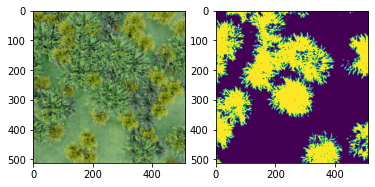

In [4]:
idx = 0
print(len(train_gen[0][0]))
print(train_gen[0][0][idx].shape, train_gen[0][1][idx].shape)
fig, axes = plt.subplots(1, 2)

axes[0].imshow(train_gen[0][0][idx])
axes[1].imshow(np.squeeze(train_gen[0][1][idx]))

fig.show()

#train_gen[0][1][idx][0]

In [5]:
tf.keras.backend.clear_session()
############################################################# 
# https://www.programmersought.com/article/16453761263/

inputs = Input(shape=img_dims)

conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D (512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal') (UpSampling2D (size = (2,2)) (drop5)) # Convolution after upsampling, Equivalent to transpose convolution operation!
merge6 = concatenate([drop4,up6],axis=3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7],axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8],axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9],axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

conv10 = Conv2D (1, 1, activation = 'sigmoid') (conv9) #I suspect that this sigmoid activation function is superfluous, because binary cross-entropy is used in the subsequent loss, including sigmoid

model = Model(inputs=[inputs], outputs=[conv10])
model.compile (optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy']) #The model must be compiled before execution https://keras-cn.readthedocs.io/en/ latest / getting_started / sequential_model /
#Using binary cross entropy, that is, sigmoid cross entropy, metrics generally use the accuracy rate, it will make the accuracy rate develop higher
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [6]:
#save best model if model improved
model_name = "tree_segm_512_cat.h5"
best_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
history = model.fit(train_gen, validation_data=val_gen, epochs=5, verbose=1, callbacks=[best_checkpoint])

In [ ]:
#print History graph
historydf = pd.DataFrame(history.history, index=history.epoch)
historydf.plot(ylim=(0,1))

C:\Users\Rock_\AppData\Local\Temp/ipykernel_14996/4246072671.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


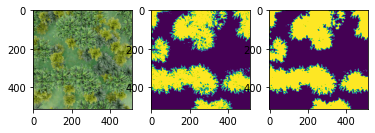

In [9]:
idx = 0
img_out_dims = (512, 512)

img = val_gen[0][0][idx]
seg = val_gen[0][1][idx]
pred = model.predict(np.expand_dims(img, axis=0)) * 255.0

_, pred_img = cv2.threshold(np.squeeze(pred), 128, 255, cv2.THRESH_BINARY)
pred_img = Image.fromarray(pred_img.astype(np.uint8))

fig, axes = plt.subplots(1, 3)
axes[0].imshow(img)
axes[1].imshow(np.squeeze(seg))
axes[2].imshow(np.squeeze(pred_img))
fig.show()